In [4]:
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.stats as st

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

### Utility functions:

In [5]:
def edge_idcs_to_incidence(edge_idcs, n=None, signed=False):
    """
    Convert a sequence of edge indices to an m x n incidence matrix
    
    :edge_idcs: 2xm index matrix of integers, gives the indices of the node endpoints of edges
    :n: number of nodes
    :signed: whether the incidence matrix should be signed
    """
    if n is None:
        n = edge_idcs.max() + 1
    m = edge_idcs.shape[0]
    incid = sp.sparse.lil_array((m,n))
    if signed:
        incid[np.arange(m),edge_idcs[:,0]] = -1
    else:
        incid[np.arange(m),edge_idcs[:,0]] = +1        
    incid[np.arange(m),edge_idcs[:,1]] = +1
    return incid

# Given some values, calculate the gap between the mean and upper/lower bound of the 95% confidence interval:
conf_int_95 = lambda a : st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))[1] - np.mean(a)

### Function for creating the TDLG:

In [6]:
def get_tdlg(edge_idcs, times, sigma_t):
    """
    Return the TDLG adjacency matrix given edge indices and edge times
    
    :sigma_t: decay rate of connections between interactions as time difference grows
    """
    
    incid = edge_idcs_to_incidence(edge_idcs, signed=False)
    
    adj_line = incid@incid.T
    adj_line_tdecay = sp.sparse.coo_array(adj_line)
    adj_line_tdecay.data *= np.exp(-((times[adj_line_tdecay.row]-times[adj_line_tdecay.col]) / (2*sigma_t))**2)
    adj_line_tdecay = sp.sparse.csr_array(adj_line_tdecay)

    return adj_line_tdecay.astype(float)

### Creating and plotting a Temporal SBM:

In [8]:
def two_comm_sbm_explicit(n, exp_deg, alpha):
    """
    Create a sampled SBM with given n (num nodes), expected degree, and alpha (homophily ratio)
    """
    u_idcs, v_idcs = np.arange(0,n//2), np.arange(n//2,n)
    num_homoph = int((alpha*exp_deg*n)//4)
    num_heteroph = int(((1-alpha)*exp_deg*n)//2)
    uu = np.hstack((np.random.choice(u_idcs, size=num_homoph)[:,None],
                     np.random.choice(u_idcs, size=num_homoph)[:,None]))
    uv = np.hstack((np.random.choice(u_idcs, size=num_heteroph)[:,None],
                     np.random.choice(v_idcs, size=num_heteroph)[:,None]))
    vv = np.hstack((np.random.choice(v_idcs, size=num_homoph)[:,None],
                     np.random.choice(v_idcs, size=num_homoph)[:,None]))
    adj = np.zeros((n,n))
    adj[uu[:,0],uu[:,1]] = 1
    adj[uv[:,0],uv[:,1]] = 1
    adj[vv[:,0],vv[:,1]] = 1
    adj = np.maximum(adj, adj.T)
    edge_labels = np.concatenate((0*np.ones(num_homoph), 1*np.ones(num_heteroph), 2*np.ones(num_homoph))).astype(int)
    return np.vstack((uu,uv,vv)), adj, edge_labels

def get_tsbm_explicit(n, exp_deg, alpha1, alpha2, mu1, mu2, sig1, sig2):
    """
    Create a sampled TSBM with given n (num nodes), expected degree, alpha1/2 (homophily ratios), and time distribs
    """
    
    edge_idcs_1, sbm1, edge_labels1 = two_comm_sbm_explicit(n, exp_deg, alpha1)
    edge_idcs_2, sbm2, edge_labels2 = two_comm_sbm_explicit(n, exp_deg, alpha2)
    
    node_labels = np.arange(n) < n//2
    m1, m2 = edge_idcs_1.shape[0], edge_idcs_2.shape[0]
    t1, t2 = np.random.normal(mu1,sig1,size=m1), np.random.normal(mu2,sig2,size=m2)

    edge_idcs = np.vstack((edge_idcs_1,edge_idcs_2))
    times = np.concatenate((t1,t2))
    edge_labels = np.concatenate((edge_labels1, edge_labels2+3))
    
    return edge_idcs, times, node_labels, edge_labels, sbm1, sbm2

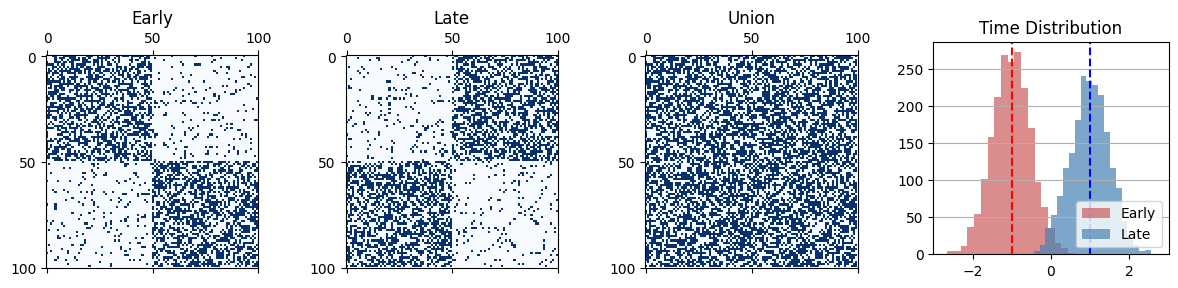

In [15]:
n = 100
exp_deg = 40
alpha1, alpha2 = 0.9, 0.1
mu1, mu2 = -1, +1
sig1, sig2 = 1/2, 1/2
edge_idcs, times, node_labels, edge_labels, sbm1, sbm2 = get_tsbm_explicit(n, exp_deg, alpha1, alpha2, mu1, mu2, sig1, sig2)

fig, axes = plt.subplots(nrows=1, ncols=4, dpi=100, figsize=(12,3))
axes[0].matshow(sbm1, cmap='Blues')
axes[0].set_title('Early')
axes[1].matshow(sbm2, cmap='Blues')
axes[1].set_title('Late')
axes[2].matshow(np.maximum(sbm1,sbm2), cmap='Blues')
axes[2].set_title('Union')
for ax in axes[:3]:
    ax.set_xticks([0,50,100])
    ax.set_yticks([0,50,100])
node_colors = np.array(['indianred', 'steelblue'])
axes[3].hist(times[edge_labels<3], alpha=0.7, bins=20, color=node_colors[0], label='Early')
axes[3].hist(times[edge_labels>=3], alpha=0.7, bins=20, color=node_colors[1], label='Late')
axes[3].axvline(-1, color='red', linestyle='--')
axes[3].axvline(+1, color='blue', linestyle='--')
axes[3].legend(loc='lower right')
axes[3].set_xlim(-3,3)
axes[3].set_title('Time Distribution')
axes[3].grid(axis='y')
plt.tight_layout()
pos = axes[3].get_position()
px, py, w, h = pos.x0, pos.y0, pos.width, pos.height
axes[3].set_position([px,py+0.045,w,h])
plt.show()

### Create and plot the time-decayed line graph of this TSBM:

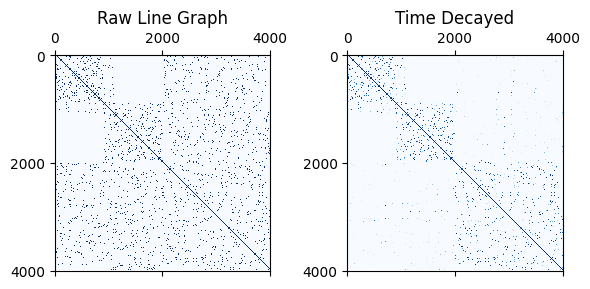

In [16]:
adj_line = get_tdlg(edge_idcs, times, sigma_t=np.inf).todense()
adj_tdlg = get_tdlg(edge_idcs, times, sigma_t=1/2).todense()

fig, axes = plt.subplots(nrows=1, ncols=2, dpi=100, figsize=(6,3))
axes[0].matshow(adj_line, cmap='Blues', vmin=0,vmax=1)
im = axes[1].matshow(adj_tdlg, cmap='Blues', vmin=0,vmax=1)
axes[0].set_title('Raw Line Graph')
axes[1].set_title('Time Decayed')
for ax in axes:
    ax.set_xticks([0,2000,4000])
    ax.set_yticks([0,2000,4000])
plt.tight_layout()
plt.show()

### Create and plot the (spectral) edge embeddings and mean-edge node embedddings:

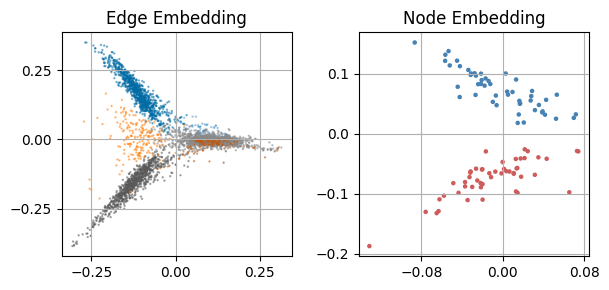

In [17]:
evals, evecs = scipy.sparse.linalg.eigsh(adj_tdlg, k=3)
edge_embed = (np.sqrt(np.abs(evals))[None,:] * evecs)[:,[1,0]] # scale evecs by evals and choose 2nd and 3rd largest evecs
norm_rows = lambda M : M / M.sum(axis=1)[:,None]
incid = edge_idcs_to_incidence(edge_idcs, n)
node_embed = norm_rows(incid.T) @ edge_embed # take the mean of embeddings of all edges of the node

fig, axes = plt.subplots(nrows=1, ncols=2, dpi=100, figsize=(6,3))
colors = np.array(plt.style.library['tableau-colorblind10']['axes.prop_cycle'].by_key()['color'])
colors = np.delete(colors,[2])
edge_colors = colors[[0,1,2,3,5,4]]

axes[0].scatter(edge_embed[:,0], edge_embed[:,1], s=0.5, 
                color=edge_colors[edge_labels.astype(int)], alpha=0.5)
axes[0].set_title('Edge Embedding')
axes[1].scatter(node_embed[:,0], node_embed[:,1], s=5, color=node_colors[node_labels.astype(int)])
axes[1].set_title('Node Embedding')
plt.tight_layout()
for ax in axes:
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.grid()
plt.show()

## Experiments on real-world graphs:

### Loading networks:

In [4]:
def load_dataset(name):
    if name == 'bitcoinalpha':
        df = pd.read_csv("./data/soc-sign-bitcoinalpha.csv", header=None, names=['Source','Target','Rating','Time'])
        edge_labels = np.array(np.sign(df['Rating'])) # reduced from -10,-9,...,+9,+10
        times = np.array(df['Time'])
    elif name == 'bitcoinotc':
        df = pd.read_csv("./data/soc-sign-bitcoinotc.csv", header=None, names=['Source','Target','Rating','Time'])
        edge_labels = np.array(np.sign(df['Rating'])) # reduced from -10,-9,...,+9,+10
        times = np.array(df['Time'])
    elif name == 'escorts':
        df = pd.read_csv("./data/escorts.edges", skiprows=6, header=None, sep=' ', 
                 names=['Source','Target','Rating','Time'])
        edge_labels = np.array(df['Rating'])
        times = np.array(df['Time'])
    elif name == 'wikielect':
        df = pd.read_csv("./data/soc-wiki-elec.edges", skiprows=0, header=None, sep=' ', 
                 names=['Source','Target','Rating', 'Time'])
        edge_labels = np.array(df['Rating'])
        times = np.array(df['Time'])
    else:
        print("No such dataset.")
        return None, None, None

    node_ids = np.unique(np.concatenate((df['Source'], df['Target'])))
    n = len(node_ids)
    node_id_to_idx = dict(zip(node_ids, np.arange(n)))

    edge_idcs = np.hstack((np.array([node_id_to_idx[id1] for id1 in df['Source']])[:,None],
                           np.array([node_id_to_idx[id2] for id2 in df['Target']])[:,None]))    
    edge_labels = np.where(edge_labels==+1, 1, 0)
    return edge_idcs, times, edge_labels

### Edge classification, AUCs and 95\% confidence intervals:

In [5]:
num_trials = 5
test_size = 0.3

for dset in ['bitcoinalpha', 'bitcoinotc', 'escorts', 'wikielect']:
    edge_idcs, times, edge_labels = load_dataset(dset)
    m = len(edge_labels)
    
    print(f"Dataset '{dset}' with {edge_idcs.max()+1} nodes and {len(times)} edges:", end='\t')
    adj_tdlg = get_tdlg(edge_idcs, times, sigma_t=(1e-1 * times.std()))
    f1s = np.zeros(num_trials)
    for i in range(num_trials):
        train_idcs, test_idcs = train_test_split(np.arange(m), test_size=test_size)
        clf = LogisticRegression(max_iter=1e3, class_weight="balanced").fit(adj_tdlg[train_idcs,:], edge_labels[train_idcs])
        f1s[i] = roc_auc_score(edge_labels[test_idcs], clf.predict_proba(adj_tdlg[test_idcs,:])[:,1])
    print(f"{f1s.mean():0.4f} +/- {conf_int_95(f1s):0.4f}")

Dataset 'bitcoinalpha' with 3783 nodes and 24186 edges:	0.9245 +/- 0.0087
Dataset 'bitcoinotc' with 5881 nodes and 35592 edges:	0.9358 +/- 0.0067
Dataset 'escorts' with 10106 nodes and 50632 edges:	0.7574 +/- 0.0028
Dataset 'wikielect' with 7118 nodes and 107071 edges:	0.9077 +/- 0.0018


### Link prediction, AUCs and 95\% confidence intervals:

In [6]:
num_trials = 3
test_size = 0.3
num_periods = 20

for dset in ['bitcoinalpha', 'bitcoinotc', 'escorts', 'wikielect']:
    pos_edge_idcs, pos_times, _ = load_dataset(dset)
    m = len(pos_times)    
    time_period = (pos_times.max()-pos_times.min()) / num_periods # time range, divided by number of time periods
    
    print(f"Dataset '{dset}' with {pos_edge_idcs.max()+1} nodes and {len(pos_times)} edges:", end='\t')
    extrap_aucs, interp_aucs = np.zeros(num_trials), np.zeros(num_trials)
    for i in range(num_trials):
        np.random.seed(i)
        neg_edge_idcs = np.hstack((np.random.permutation(pos_edge_idcs[:,0])[:,None], 
                                   np.random.permutation(pos_edge_idcs[:,1])[:,None])) # permute 
        neg_times = np.random.permutation(pos_times)
        train_idcs, test_idcs = train_test_split(np.arange(2*m), test_size=test_size)
        
        all_edge_idcs = np.vstack((pos_edge_idcs, neg_edge_idcs))
        all_times = np.concatenate((pos_times, neg_times))
        all_edge_labels = np.zeros(2*m, dtype=bool)
        all_edge_labels[:m] = 1 # first m edges are positive/true edges, rest are negative

        early_mask, late_mask = np.zeros(2*m, dtype=bool), np.zeros(2*m, dtype=bool) # mask to separate edges in last time period from others
        late_mask[np.clip((all_times - all_times.min()) // time_period, 0, num_periods-1) == num_periods-1] = 1
        early_mask = ~late_mask

        train_mask, test_mask = np.zeros(2*m, dtype=bool), np.zeros(2*m, dtype=bool)
        train_mask[train_idcs] = 1
        test_mask[test_idcs] = 1
        
        train_early = train_mask & early_mask
        adj_tdlg = get_tdlg(all_edge_idcs, all_times, sigma_t=(1e-1 * all_times[train_early].std()))
        adj_tdlg = adj_tdlg[:,train_early] # can only use proximity to training data as training features
        
        clf = LogisticRegression(max_iter=1e3, class_weight="balanced").fit(adj_tdlg[train_early,:],
                                                                            all_edge_labels[train_early])
        extrap_aucs[i] = roc_auc_score(all_edge_labels[late_mask], 
                                       clf.predict_proba(adj_tdlg[late_mask,:])[:,1]) # predict over late edges
        interp_aucs[i] = roc_auc_score(all_edge_labels[test_mask & early_mask], 
                                       clf.predict_proba(adj_tdlg[test_mask & early_mask,:])[:,1]) # predict over early test edges
    print(f"Extrap:\t{extrap_aucs.mean():0.4f} +/- {conf_int_95(extrap_aucs):0.4f}\tInterp:\t{interp_aucs.mean():0.4f} +/- {conf_int_95(interp_aucs):0.4f}")

Dataset 'bitcoinalpha' with 3783 nodes and 24186 edges:	Extrap:	0.9596 +/- 0.0386	Interp:	0.9298 +/- 0.0032
Dataset 'bitcoinotc' with 5881 nodes and 35592 edges:	Extrap:	0.8123 +/- 0.0307	Interp:	0.9342 +/- 0.0027
Dataset 'escorts' with 10106 nodes and 50632 edges:	Extrap:	0.6506 +/- 0.0173	Interp:	0.7924 +/- 0.0034
Dataset 'wikielect' with 7118 nodes and 107071 edges:	Extrap:	0.7185 +/- 0.0188	Interp:	0.9842 +/- 0.0002
